In [1]:
# Load data

import os
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 40000)
pd.set_option('display.max_rows', None)

# Read the data from the CSV file
df_safegraph_spend = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_SPEND_Yellowstone_200miRadius.csv.gz'))

# Print the first 5 rows of the DataFrame
# print(df_safegraph_spend.info())
# print(df_safegraph_spend.head())


In [2]:
# Filter by Geographic Region

# Create a geojson file using this online tool: https://geojson.io/#map=6.57/43.031/-108.404

import geopandas as gpd

filter_region = gpd.read_file(os.path.join('..', 'map','Cooke_City.geojson')) # Put your new location geojson file here

# The following code does a 2-step filtering process: 1) filter the POI down to be within the region, 2) use the POI set to filter the SPEND data

# 1 - Filter POI within the filter_region
df_safegraph_poi = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_POI_Yellowstone_200miRadius.csv.gz'))

# print('(before filter) # of rows: ', len(df_safegraph_poi))

if 'LONGITUDE' in df_safegraph_poi.columns and 'LATITUDE' in df_safegraph_poi.columns:
    points = gpd.points_from_xy(df_safegraph_poi['LONGITUDE'], df_safegraph_poi['LATITUDE'])
    mask = points.within(filter_region.geometry.iloc[0])  # Assuming filter_region has only one polygon
    df_safegraph_poi_filtered = df_safegraph_poi[mask]
else:
    print("Error: DataFrame does not contain 'LONGITUDE' and/or 'LATITUDE' columns.")

# print('(after filter)  # of rows: ', len(df_safegraph_poi_filtered))
# print(df_safegraph_poi_filtered.head())

# 2 - Filter SPEND data by matching the PLACEKEY with the filtered POI
# print('(before filter) # of rows: ', len(df_safegraph_spend))

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_filtered = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_safegraph_poi_filtered['PLACEKEY'])]
else:
    print("Error: DataFrame does not contain 'PLACEKEY' column.")

# print('(after filter)  # of rows: ', len(df_filtered))
# print(df_filtered.head())


In [3]:
# Filter by Dates

# print('(before filter) # of rows: ', len(df_filtered))
df = df_filtered.copy()

datetime_start = pd.to_datetime('2019-05-01')
datetime_end = pd.to_datetime('2019-09-01')

df_safegraph_spend['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_START'])
df_safegraph_spend['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_END'])

df_filtered_2019 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_safegraph_spend['SPEND_DATE_RANGE_END'] <= datetime_end)]

#print('(after filter) # of rows: ', len(df_filtered))
print(df_filtered_2019.head())

                  PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    REL

C:\Users\tjbla\AppData\Local\Temp\ipykernel_5292\1004588570.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_2019 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &


In [4]:
import ast  # For safely evaluating strings containing Python literals

df = df_filtered_2019.copy()

# Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
df['SPEND_BY_DAY'] = df['SPEND_BY_DAY'].apply(ast.literal_eval)

# Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
df['DATE_OF_MONTH'] = df['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

print(df.head())

# Explode both 'SPEND_BY_DAY' and 'DATE_OF_MONTH' simultaneously to keep their mapping correct
df_spend_by_day = df.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

# Convert the spending amounts to float
df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)


# Calculate 'DATE' correctly by subtracting 1 since 'DATE_OF_MONTH' starts from 1, not 0
df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')
df_spend_by_day['DATE'] = df_spend_by_day['DATE'].dt.strftime('%m-%d')

# Ensure the DataFrame is sorted by 'DATE' if not already
# df_spend_by_day = df_spend_by_day.sort_values('DATE')

#print('# of rows: ', len(df_spend_by_day))
#print(df_spend_by_day.head(10))

# Plot df_spend_by_day using plotly
#fig = px.scatter(df_spend_by_day, x='DATE', y='SPEND_BY_DAY', title='Daily Spend', labels={'SPEND_BY_DAY': 'Spend ($)'})

#fig.show()

grouped_19_ccmt = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()

                  PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    REL

In [5]:
# Filter by Dates

# print('(before filter) # of rows: ', len(df_filtered))
df = df_filtered.copy()

datetime_start = pd.to_datetime('2021-05-01')
datetime_end = pd.to_datetime('2021-09-01')

df_safegraph_spend['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_START'])
df_safegraph_spend['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_END'])

df_filtered_2021 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_safegraph_spend['SPEND_DATE_RANGE_END'] <= datetime_end)]

#print('(after filter) # of rows: ', len(df_filtered))
print(df_filtered_2021.head())


                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RE

C:\Users\tjbla\AppData\Local\Temp\ipykernel_5292\1595654646.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_2021 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &


In [6]:
# Make a Plot of the Data

# Note: 'SPEND_DATE_RANGE_START' and 'SPEND_DATE_RANGE_END' is typically separated by 1 month (~30 days)
#       'SPEND_BY_DAY' is each spend data for each day of the month
# Goal; Plot spending for each single day using plotly

#import plotly.express as px
import ast  # For safely evaluating strings containing Python literals

df = df_filtered_2021.copy()

# Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
df['SPEND_BY_DAY'] = df['SPEND_BY_DAY'].apply(ast.literal_eval)

# Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
df['DATE_OF_MONTH'] = df['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

print(df.head())

# Explode both 'SPEND_BY_DAY' and 'DATE_OF_MONTH' simultaneously to keep their mapping correct
df_spend_by_day = df.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

# Convert the spending amounts to float
df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)


# Calculate 'DATE' correctly by subtracting 1 since 'DATE_OF_MONTH' starts from 1, not 0
df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')
df_spend_by_day['DATE'] = df_spend_by_day['DATE'].dt.strftime('%m-%d')

# Ensure the DataFrame is sorted by 'DATE' if not already
# df_spend_by_day = df_spend_by_day.sort_values('DATE')

#print('# of rows: ', len(df_spend_by_day))
#print(df_spend_by_day.head(10))

# Plot df_spend_by_day using plotly
#fig = px.scatter(df_spend_by_day, x='DATE', y='SPEND_BY_DAY', title='Daily Spend', labels={'SPEND_BY_DAY': 'Spend ($)'})

#fig.show()

grouped_21_ccmt = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()


                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RE

In [7]:
# Filter by Dates

# print('(before filter) # of rows: ', len(df_filtered))
df = df_filtered.copy()

datetime_start = pd.to_datetime('2022-05-01')
datetime_end = pd.to_datetime('2022-09-01')

df_safegraph_spend['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_START'])
df_safegraph_spend['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_END'])

df_filtered_2022 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_safegraph_spend['SPEND_DATE_RANGE_END'] <= datetime_end)]

#print('(after filter) # of rows: ', len(df_filtered))
print(df_filtered_2022.head())


                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RE

C:\Users\tjbla\AppData\Local\Temp\ipykernel_5292\4196244775.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_2022 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &


In [8]:
# Make a Plot of the Data

# Note: 'SPEND_DATE_RANGE_START' and 'SPEND_DATE_RANGE_END' is typically separated by 1 month (~30 days)
#       'SPEND_BY_DAY' is each spend data for each day of the month
# Goal; Plot spending for each single day using plotly

import plotly.express as px
import ast  # For safely evaluating strings containing Python literals
import matplotlib.pyplot as plt

df = df_filtered_2022.copy()

# Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
df['SPEND_BY_DAY'] = df['SPEND_BY_DAY'].apply(ast.literal_eval)

# Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
df['DATE_OF_MONTH'] = df['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

#print(df.head())

# Explode both 'SPEND_BY_DAY' and 'DATE_OF_MONTH' simultaneously to keep their mapping correct
df_spend_by_day = df.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

# Convert the spending amounts to float
df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)


# Calculate 'DATE' correctly by subtracting 1 since 'DATE_OF_MONTH' starts from 1, not 0
df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')
df_spend_by_day['DATE'] = df_spend_by_day['DATE'].dt.strftime('%m-%d')

# Ensure the DataFrame is sorted by 'DATE' if not already
# df_spend_by_day = df_spend_by_day.sort_values('DATE')

grouped_22_ccmt = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()
#print(grouped_22.head(10))


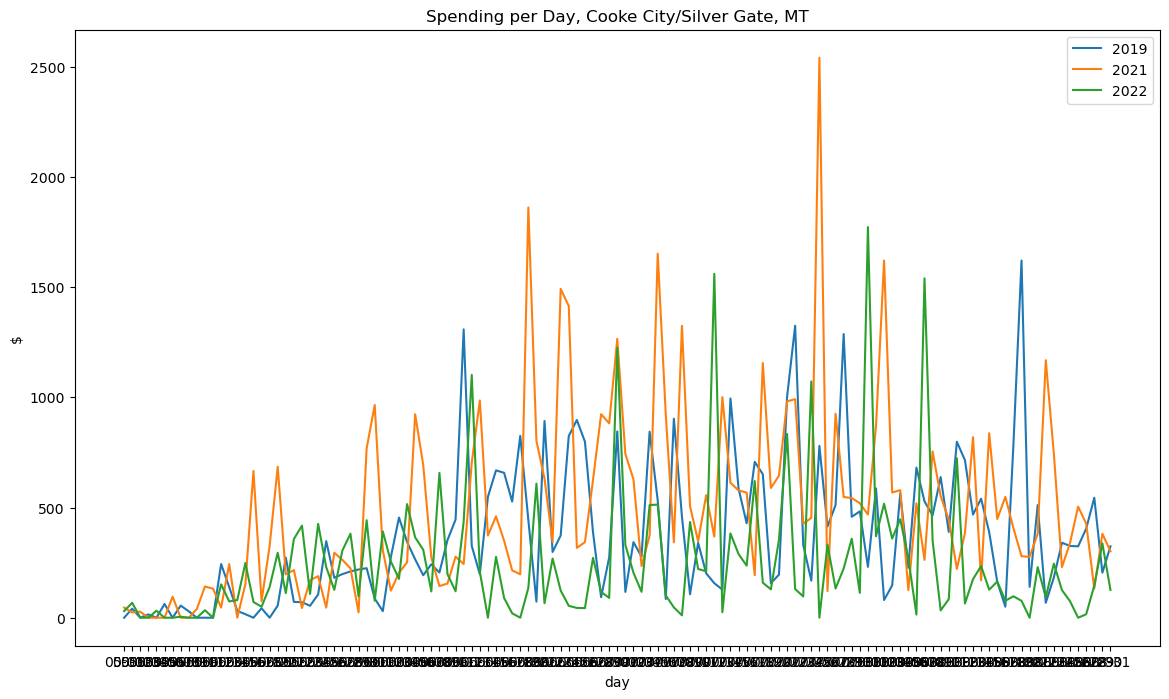

In [9]:
# Plot the overall spending

plt.figure(figsize=(14, 8))

plt.plot(grouped_19_ccmt);
plt.plot(grouped_21_ccmt);
plt.plot(grouped_22_ccmt);
plt.title('Spending per Day, Cooke City/Silver Gate, MT');
plt.xlabel('day');
plt.ylabel('$');
plt.legend(['2019', '2021', '2022']);

plt.savefig('General_Cooke_City_Spending_2019-2022.png');

In [14]:
# Filter by Dates

# print('(before filter) # of rows: ', len(df_filtered))
df = df_filtered.copy()

datetime_start = pd.to_datetime('2023-05-01')
datetime_end = pd.to_datetime('2023-09-01')

df_safegraph_spend['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_START'])
df_safegraph_spend['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_safegraph_spend['SPEND_DATE_RANGE_END'])

df_filtered_2023 = df[(df_safegraph_spend['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_safegraph_spend['SPEND_DATE_RANGE_END'] <= datetime_end)]

#print('(after filter) # of rows: ', len(df_filtered))
print(df_filtered_2023.head())


                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RE

C:\Users\tjbla\AppData\Local\Temp\ipykernel_21468\2773158075.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [18]:
# Make a Plot of the Data

# Note: 'SPEND_DATE_RANGE_START' and 'SPEND_DATE_RANGE_END' is typically separated by 1 month (~30 days)
#       'SPEND_BY_DAY' is each spend data for each day of the month
# Goal; Plot spending for each single day using plotly

import plotly.express as px
import ast  # For safely evaluating strings containing Python literals

df = df_filtered_2023.copy()

# Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
df['SPEND_BY_DAY'] = df['SPEND_BY_DAY'].apply(ast.literal_eval)

# Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
df['DATE_OF_MONTH'] = df['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

print(df.head())

# Explode both 'SPEND_BY_DAY' and 'DATE_OF_MONTH' simultaneously to keep their mapping correct
df_spend_by_day = df.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

# Convert the spending amounts to float
df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)


# Calculate 'DATE' correctly by subtracting 1 since 'DATE_OF_MONTH' starts from 1, not 0
df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')

# Ensure the DataFrame is sorted by 'DATE' if not already
# df_spend_by_day = df_spend_by_day.sort_values('DATE')

#print('# of rows: ', len(df_spend_by_day))
#print(df_spend_by_day.head(10))

# Plot df_spend_by_day using plotly
#fig = px.scatter(df_spend_by_day, x='DATE', y='SPEND_BY_DAY', title='Daily Spend', labels={'SPEND_BY_DAY': 'Spend ($)'})

#fig.show()

grouped_23 = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()
print(grouped_23.head(10))
fig = px.line(grouped_23, title='Daily Spending 2023')
fig.show()


                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RE

c:\Users\tjbla\miniforge3\envs\worth\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [22]:
spending = pd.DataFrame()
spending['DATE'] = df_spend_by_day['DATE']
spending['2021'] = 

print(spending.head(10))

         DATE
163061  07-01
163061  07-02
163061  07-03
163061  07-04
163061  07-05
163061  07-06
163061  07-07
163061  07-08
163061  07-09
163061  07-10
